<a href="https://colab.research.google.com/github/Boyinglby/personal/blob/main/HealthCare_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Dense
import copy
import keras
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay

# OOP class Preprocess

In [ ]:
class Preprocess:

  def __init__(self, name, file):
    self.name = name
    self.file = file

  def load(self):
    self.df = pd.read_csv(self.file)

  def inspect_data(self):
    """
    Inspect the basic info of the dataframe
    """
    print("Head of dataframe:\n", self.df.head())
    print("---------------------------\n")
    print("Data frame shape:\n", self.df.shape)
    print("---------------------------\n")
    print("Statistics summary of data:\n", self.df.describe(include='all'))
    print("---------------------------\n")
    print("Missing data check:\n", self.df.isna().sum())


  def visualize_data(self, feature):
    """
    Visualize dataset with histogram,
    boxplot and correlation heatmap
    to understand the data
    """
    # data imbalance

    self.df["Outcome"].hist()
    plt.title("Dataset class distribution")
    plt.show()

    # box plot of features
    sns.boxplot(self.df[feature])
    plt.title(f"Box plot of {self.name} features")
    plt.xticks(rotation=90)
    plt.show()

    # correlation heatmap plot
    self.corr = self.df.corr()
    sns.heatmap(self.corr,annot=False)
    plt.title("correlation heatmap")
    plt.show()
    return self.corr

  def feature_selec(self, feature, p_thres=0.05):
    """
    Examine the relationship between each features
    and the dependent variable(diagnosis) one by one.
    """
    self.significant_variables = []
    self._X = self.df[feature]
    self.Y = self.df["Outcome"]

    for column in self._X.columns:
      t_statistic, p_value = stats.ttest_ind(
                              self._X[column][self.Y == 0],
                              self._X[column][self.Y == 1]
                              )

      # print(f"T-statistic for the variable {column} with the dependent variable: {t_statistic}")
      # print(f"P-value for the variable {column} with the dependent variable: {p_value}")

      if p_value < p_thres:
        # print("With a p-value less than 0.05, we reject the null hypothesis.
        # There's a significant difference between the variable and the dependent variable.\n")
        self.significant_variables.append(column)
      # else:
        # print("With a p-value greater than or equal to 0.05, we fail to reject the null hypothesis.
        # There's no significant difference between the variable and the dependent variable.\n")
    self.X = self.df.loc[:, self.significant_variables]

    return self.significant_variables

  def split_data(self, test_ratio=0.3):
    """
    split dataset into train and test sets
    """
    self.X_train, self.X_test, self.Y_train, self.Y_test = \
    train_test_split(self.X, self.Y, test_size=test_ratio, random_state=42)
    return self.X_train, self.X_test, self.Y_train, self.Y_test

  def norm_data(self):
    """
    normalize data
    """
    scaler = StandardScaler()
    self.X_train = scaler.fit_transform(self.X_train)
    self.X_test = scaler.transform(self.X_test)
    return self.X_train, self.X_test

  def oversample(self):
    ros = RandomOverSampler(random_state=0)
    self.X_train, self.Y_train = ros.fit_resample(self.X_train, self.Y_train)
    return self.X_train, self.Y_train


# Loading Dataset

In [ ]:
Diabetes = Preprocess("diabetes_data", "diabetes.csv")
Diabetes.load()

# Data inspection and visualization

In [ ]:
Diabetes.inspect_data()

Head of dataframe:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
---------------------------

Data frame shape:
 (768, 9)
---------------------------

Statistics summary of data:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.8450

In [ ]:
Diabetes.df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

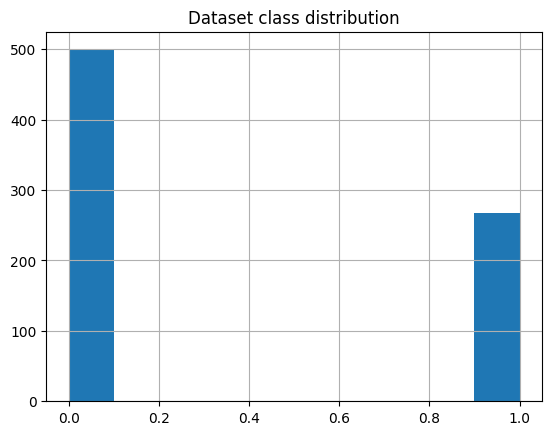

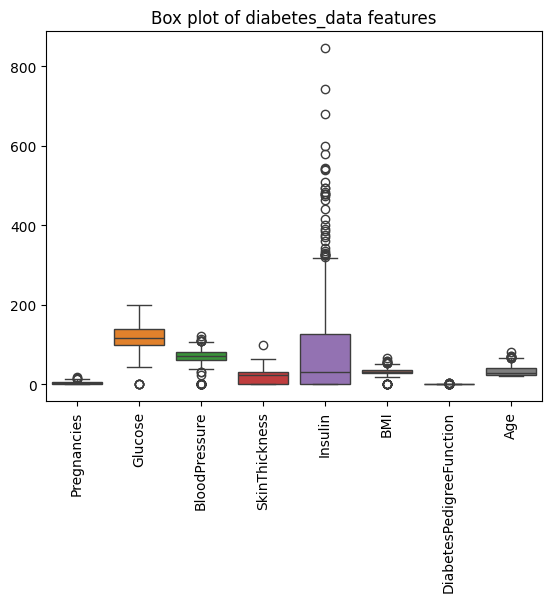

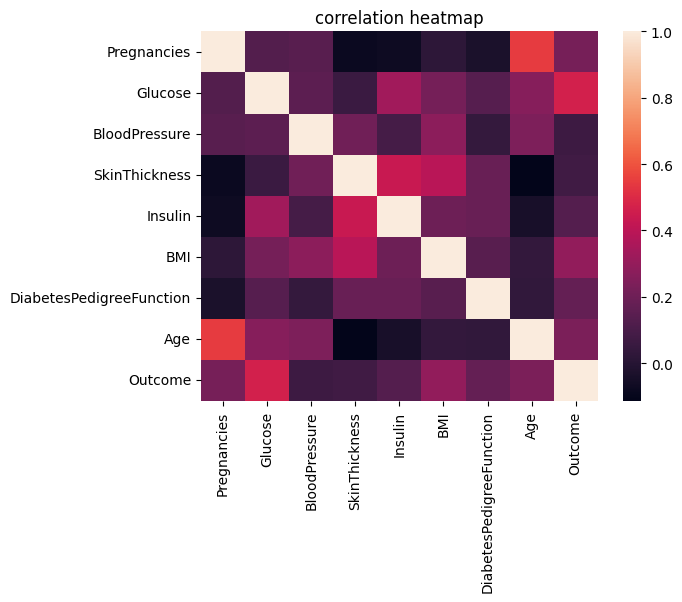

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [ ]:
feature = Diabetes.df.columns[:-1]
Diabetes.visualize_data(feature)

# Feature selection

In [ ]:
significant_variables = Diabetes.feature_selec(feature)

In [ ]:
significant_variables

['Pregnancies',
 'Glucose',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

# Splitting Dataset

In [ ]:
X_train, X_test, Y_train, Y_test = Diabetes.split_data()

# Normalize data

In [ ]:
X_train, X_test = Diabetes.norm_data()

# Oversampling train data

In [ ]:
X_train, Y_train = Diabetes.oversample()

In [ ]:
Y_train.value_counts()

Outcome
0    349
1    349
Name: count, dtype: int64

# OOP model class

In [ ]:
class BinaryClassifier:

  def __init__(self, name, model, X_train, Y_train, X_test, Y_test):
    self.name = name
    self.model = model
    self.X_train = X_train
    self.Y_train = Y_train
    self.X_test = X_test
    self.Y_test = Y_test

  def grid_search_hyperparam(self, param_grid, scoring, cv=10):
    """
    grid search hyperparameters for optimal model
    """
    grid_search = GridSearchCV(param_grid=param_grid, cv=cv,
                               scoring=scoring, estimator=self.model)
    grid_search.fit(self.X_train, self.Y_train)

    self.best_params = grid_search.best_params_
    self.model = grid_search.best_estimator_
    print(f"best param of {self.model} is {self.best_params}")
    return self.best_params

  def train(self):
    """
    train the model with train set
    return: prediction of test data
    """
    self.model.fit(self.X_train, self.Y_train)
    self.Y_pred = self.model.predict(X_test)
    return self.Y_pred

  def eval(self, cm_label):
    """
    evaluate model's performace with
    confusuion matrix and return a table
    summarize various metrics score

    """
    score = []
    score.append(accuracy_score(self.Y_test, self.Y_pred))
    score.append(precision_score(self.Y_test, self.Y_pred))
    score.append(recall_score(self.Y_test, self.Y_pred))
    score.append(f1_score(self.Y_test, self.Y_pred))

    result = pd.DataFrame({
      'Metrics': ['Accuracy','Precision', 'Recall','F1'],
      self.name: score})

    cm = confusion_matrix(self.Y_test, self.Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=cm_label).plot()
    disp.ax_.set_title(f"Confusion matrix with {self.name}")

    return result

In [ ]:

class ANN(BinaryClassifier):

  def __init__(self, name, model, X_train, Y_train, X_test, Y_test):
    super().__init__(name, model, X_train, Y_train, X_test, Y_test)

  def train(self, epochs):
    """
    train the ANN model with train set
    save the best model with highest recall
    use the best model to predict test set
    """
    self.model.compile(loss='binary_crossentropy', optimizer='adam',
                       metrics=['accuracy', keras.metrics.Recall(name="recall")])


    self.early_stopping = EarlyStopping(monitor="val_recall", mode='max',
                                        patience=30, restore_best_weights=True)
    self.hist = self.model.fit(self.X_train, self.Y_train,
                               validation_split=0.3, epochs=epochs,
                               batch_size=10, verbose=1,
                               callbacks=[self.early_stopping])
    self.Y_pred = self.model.predict(self.X_test)
    self.Y_pred = np.squeeze(self.Y_pred)
    self.Y_pred =  [round(x) for x in self.Y_pred]

  def eval(self, cm_label):
    """
    plot the train loss and test loss along epochs
    evaluate model's performace with confusuion
    matrix and return a table summarize various
    metrics score

    """

    plt.plot(self.hist.history['loss'])
    plt.plot(self.hist.history['val_loss'])
    plt.title('MLP Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

    score = []
    score.append(accuracy_score(self.Y_test, self.Y_pred))
    score.append(precision_score(self.Y_test, self.Y_pred))
    score.append(recall_score(self.Y_test, self.Y_pred))
    score.append(f1_score(self.Y_test, self.Y_pred))

    result = pd.DataFrame({
      'Metrics': ['Accuracy','Precision', 'Recall','F1'],
      self.name: score})

    cm = confusion_matrix(self.Y_test, self.Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=cm_label).plot()
    disp.ax_.set_title(f"Confusion matrix with {self.name}")

    return result


In [ ]:
cm_label=['Negative', 'Positive']

# Logistic regression

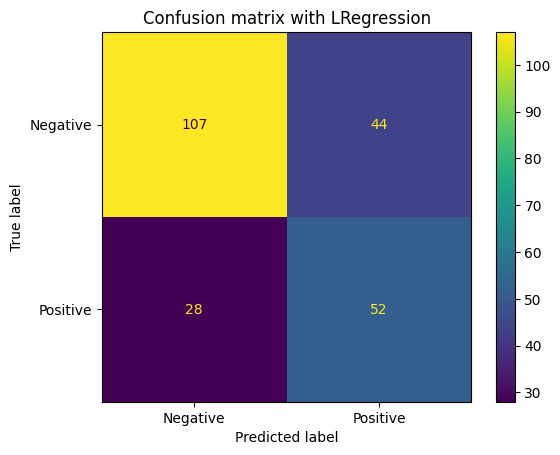

In [ ]:
LRegression = BinaryClassifier("LRegression", LogisticRegression(), X_train, Y_train, X_test, Y_test)
LRegression.train()
result_lr = LRegression.eval(cm_label)

In [ ]:
# Get detailed coefficient results
log_odds = LRegression.model.coef_[0]
pd.DataFrame(log_odds,
             Diabetes.X.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
Glucose,1.114020
BMI,0.775501
Age,0.372518
Pregnancies,0.178487
DiabetesPedigreeFunction,0.148377
SkinThickness,-0.049026
Insulin,-0.095437


In [ ]:
# log odd coefficients need to be converted to regular odds in order to make sense of them.
# This is done by simply exponentiating the log odds coefficients

odds = np.exp(LRegression.model.coef_[0])
pd.DataFrame(odds,
             Diabetes.X.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

# how to interpret coef: https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1
# “For every one-unit increase in [texture_worst], the odds that the observation is in malignant class
# are 3.34 times as large as the odds that the observation is not in malignant class when
# all other variables are held constant.”

,coef
Glucose,3.046581
BMI,2.171680
Age,1.451385
Pregnancies,1.195407
DiabetesPedigreeFunction,1.159950
SkinThickness,0.952156
Insulin,0.908976


# KNN

best param of KNeighborsClassifier(n_neighbors=1) is {'n_neighbors': 1}


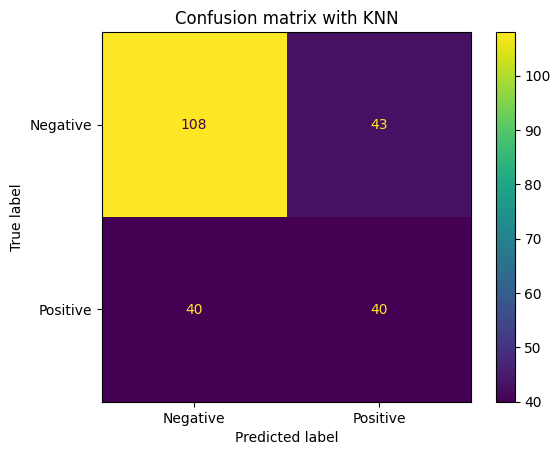

In [ ]:
KNN = BinaryClassifier("KNN", KNeighborsClassifier(), X_train, Y_train, X_test, Y_test)

k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)

KNN.grid_search_hyperparam(param_grid, "recall")
KNN.train()
result_knn = KNN.eval(cm_label)

# SVM

best param of SVC(C=0.1, gamma=1) is {'C': 0.1, 'gamma': 1}


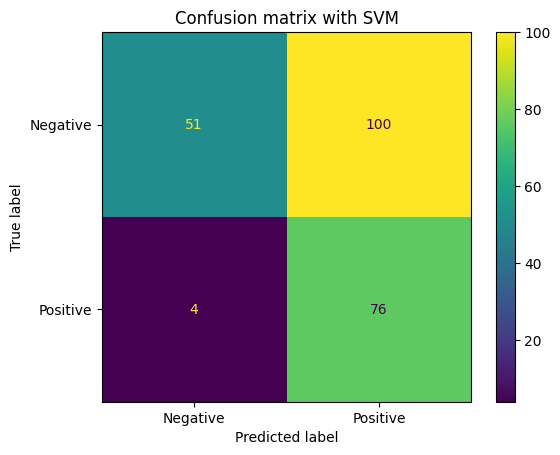

In [ ]:
SVM = BinaryClassifier("SVM", SVC(), X_train, Y_train, X_test, Y_test)

param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001]}
SVM.grid_search_hyperparam(param_grid, "recall")
SVM.train()
result_svm = SVM.eval(cm_label)

In [ ]:
# get number of support vectors for each class
SVM.model.n_support_

array([45, 49], dtype=int32)

# Decision Tree

best param of DecisionTreeClassifier(max_depth=11) is {'criterion': 'gini', 'max_depth': 11}


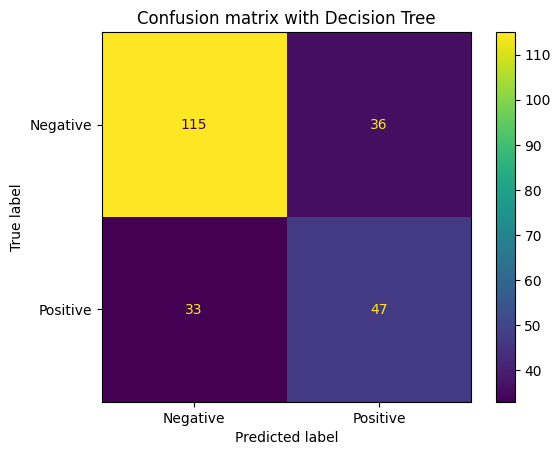

In [ ]:
DT = BinaryClassifier("Decision Tree", DecisionTreeClassifier(), X_train, Y_train, X_test, Y_test)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 15)
}

DT.grid_search_hyperparam(param_grid, "recall")
DT.train()
result_dt = DT.eval(cm_label)

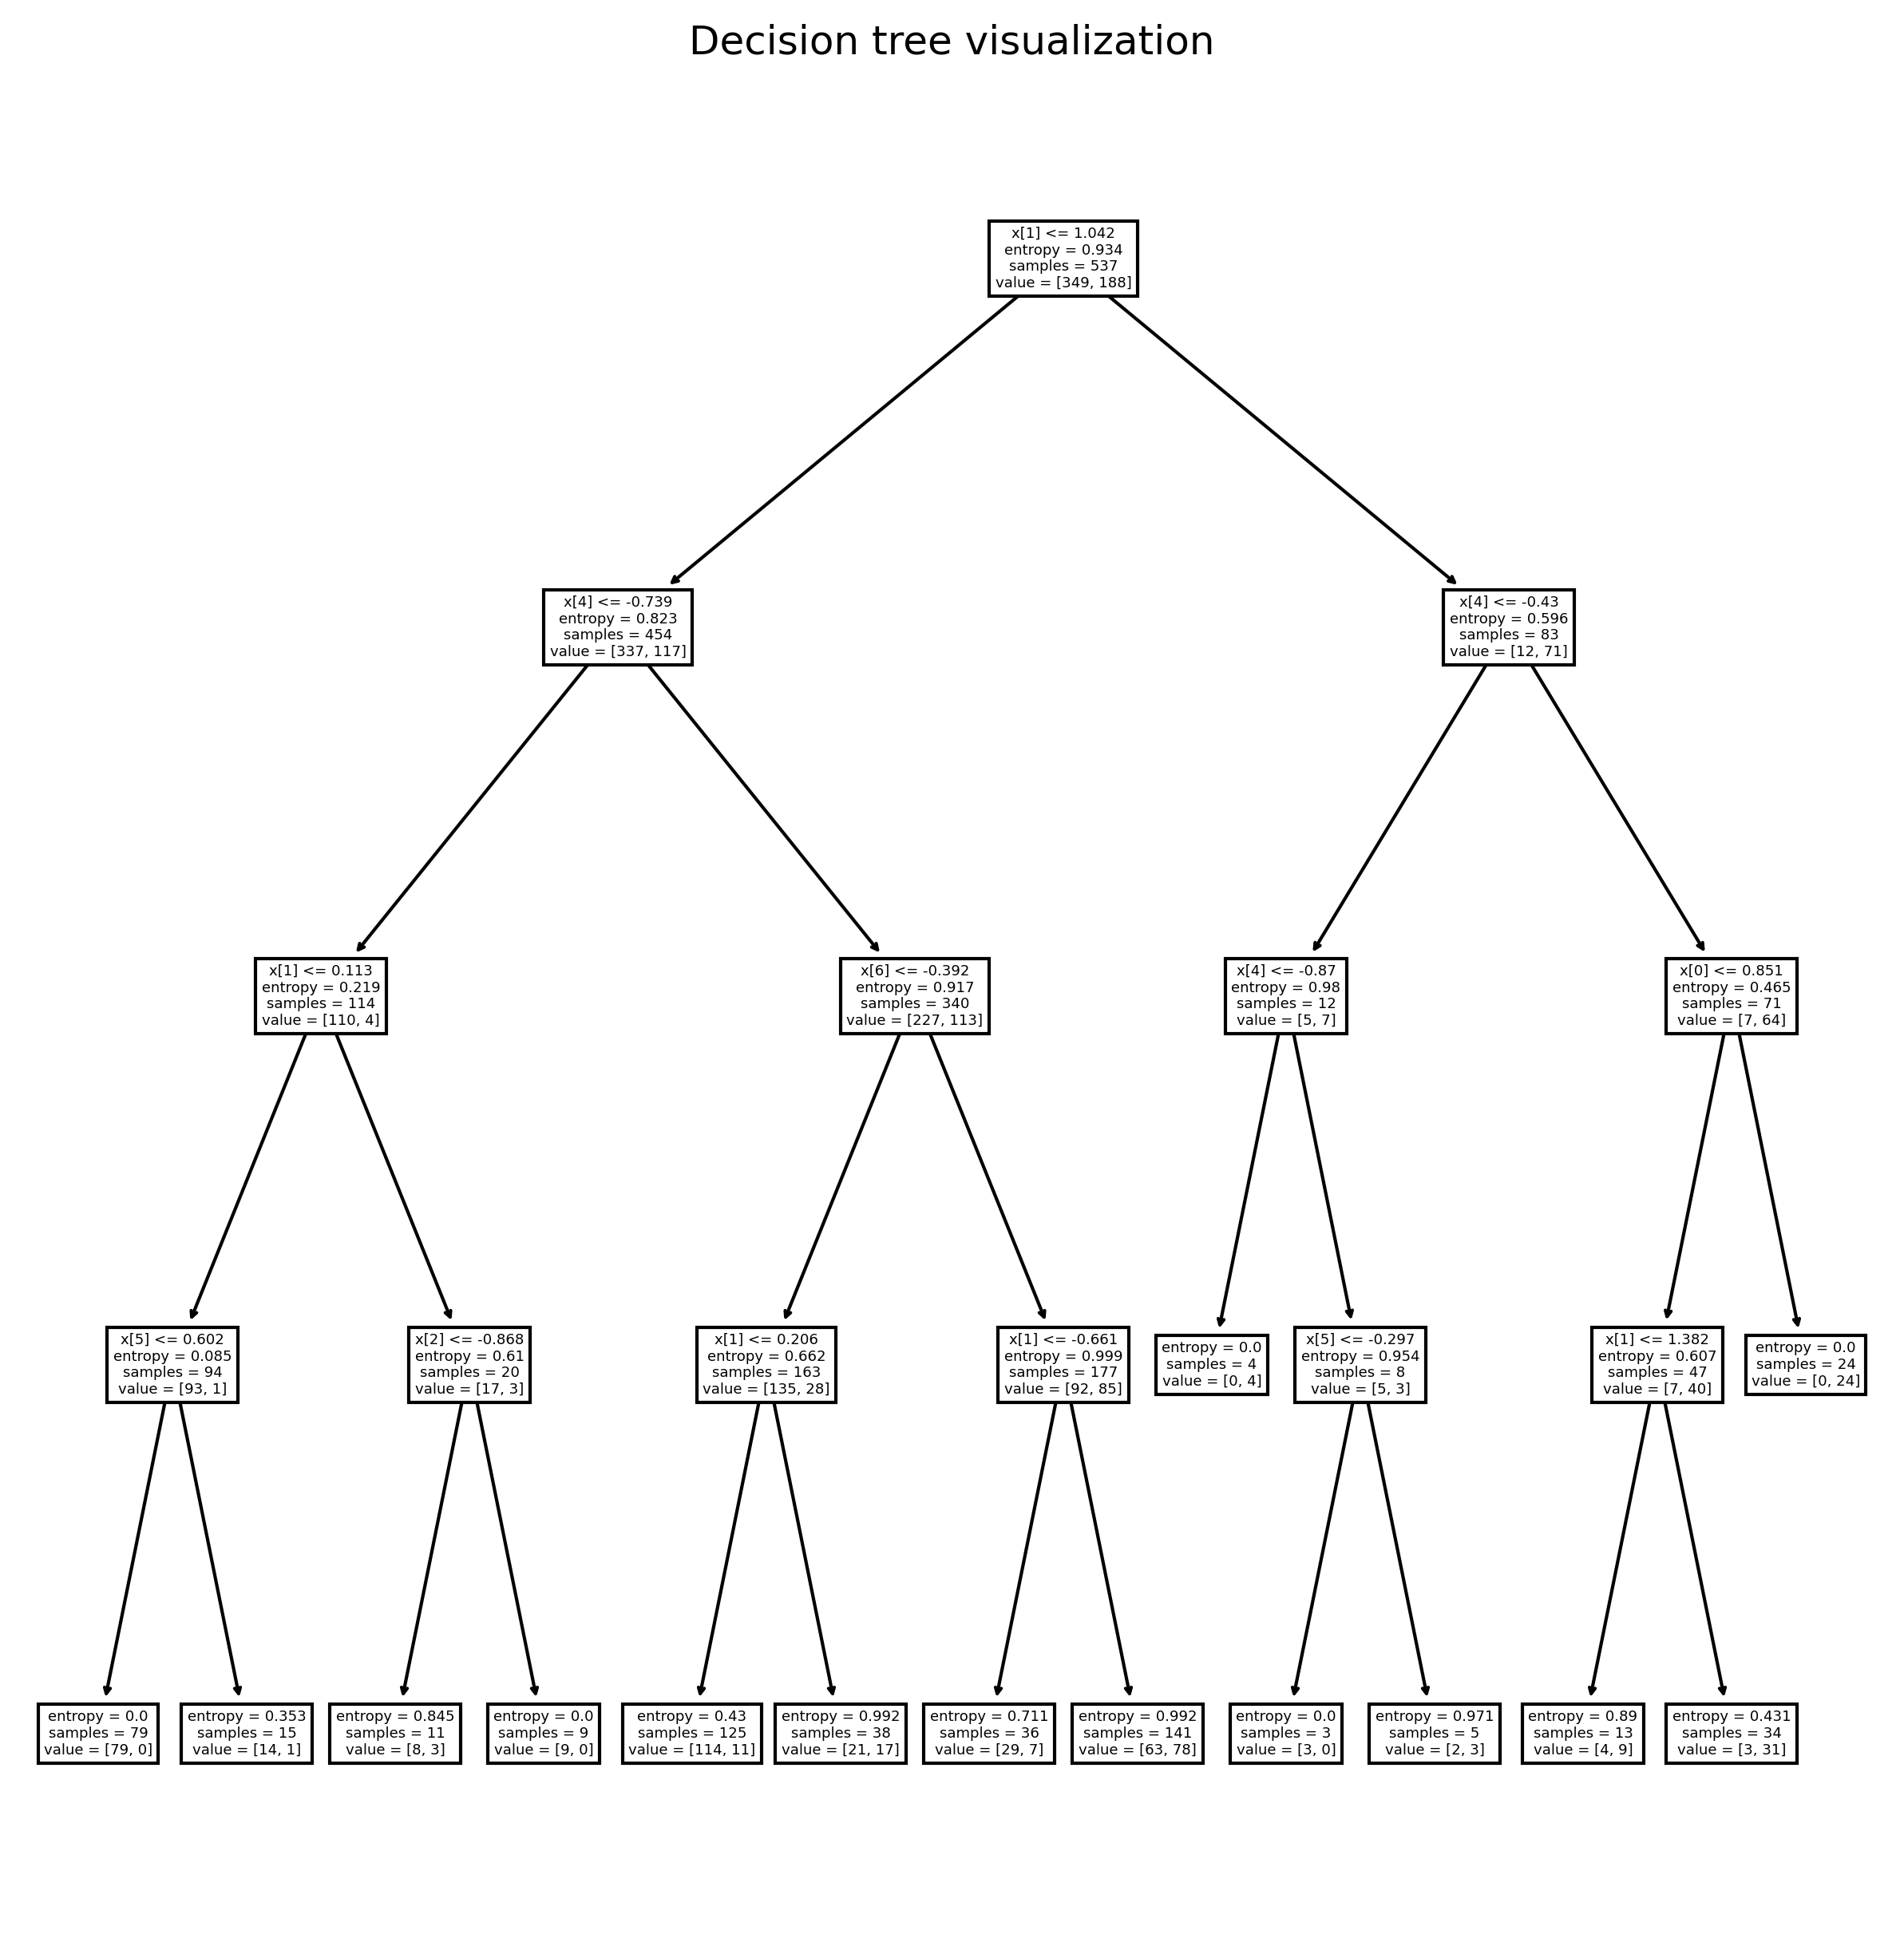

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10), dpi=300)
sklearn.tree.plot_tree(DT.model)
plt.title("Decision tree visualization")
plt.show()

# RF

best param of RandomForestClassifier(max_depth=10, n_estimators=80, random_state=1) is {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 80}


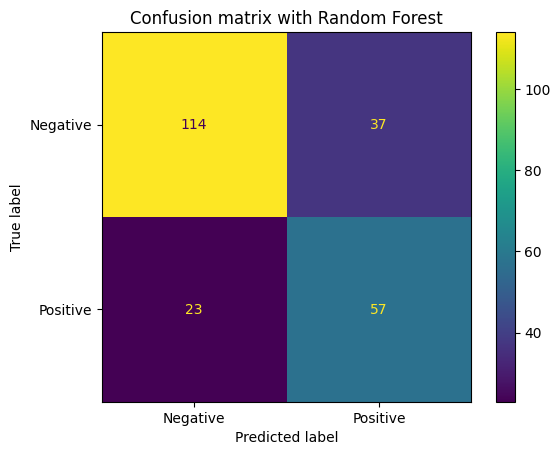

In [ ]:

RF = BinaryClassifier("Random Forest", RandomForestClassifier(random_state=1), X_train, Y_train, X_test, Y_test)
param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10]
}
RF.grid_search_hyperparam(param_grid, "recall")
RF.train()
result_rf = RF.eval(cm_label)

# ANN

Epoch 1/50
49/49 [==============================] - 1s 7ms/step - loss: 0.6749 - accuracy: 0.6455 - recall: 0.0060 - val_loss: 0.8810 - val_accuracy: 0.1714 - val_recall: 0.0387
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6742 - recall: 0.0655 - val_loss: 0.8089 - val_accuracy: 0.2286 - val_recall: 0.1050
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 0.5695 - accuracy: 0.7152 - recall: 0.2560 - val_loss: 0.7548 - val_accuracy: 0.4048 - val_recall: 0.3149
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 0.5293 - accuracy: 0.7684 - recall: 0.4643 - val_loss: 0.7157 - val_accuracy: 0.5714 - val_recall: 0.5138
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 0.4986 - accuracy: 0.7807 - recall: 0.5298 - val_loss: 0.6825 - val_accuracy: 0.6286 - val_recall: 0.5967
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.7869 - recall: 0.

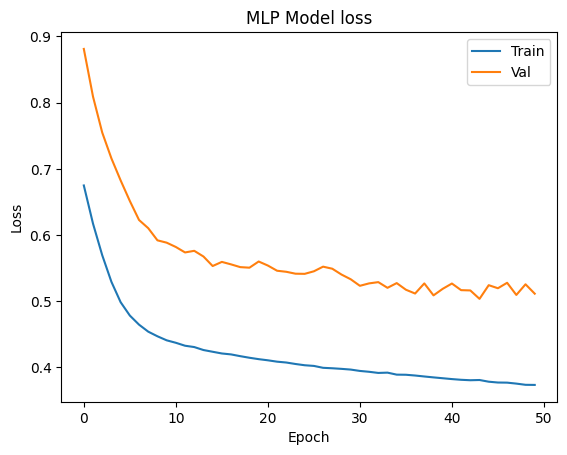

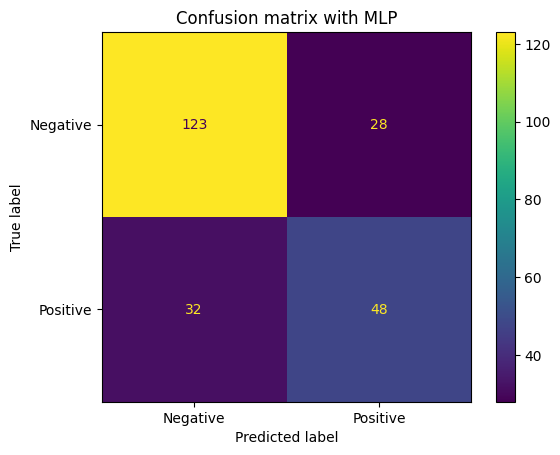

In [ ]:
model = Sequential([
    Dense(15, activation='relu', input_shape=(len(significant_variables),)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid'),
])
MLP = ANN("MLP", model, X_train, Y_train, X_test, Y_test)
MLP.train(50)
result_mlp = MLP.eval(cm_label)

# Result summary

In [ ]:
result_sum = result_lr.join([result_knn["KNN"], result_svm["SVM"],
                             result_mlp["MLP"], result_dt["Decision Tree"],
                             result_rf["Random Forest"]])
result_sum

,Metrics,LRegression,KNN,SVM,MLP,Decision Tree,Random Forest
0,Accuracy,0.688312,0.640693,0.549784,0.740260,0.701299,0.740260
1,Precision,0.541667,0.481928,0.431818,0.631579,0.566265,0.606383
2,Recall,0.650000,0.500000,0.950000,0.600000,0.587500,0.712500
3,F1,0.590909,0.490798,0.593750,0.615385,0.576687,0.655172


# Voting classifer

# Hard voting

In [ ]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier(random_state=1)
svm_clf = SVC(probability=True)
mlp_clf = MLPClassifier(hidden_layer_sizes=(20, 10), validation_fraction=0.2,
                        solver='adam',random_state=1, learning_rate_init=1e-2,
                        max_iter=100, early_stopping=True, warm_start=True)
dt_clf = DecisionTreeClassifier()
knn_clf = KNeighborsClassifier()

eclf1 = VotingClassifier(estimators=[
    ('lr',log_clf), ('rf', rnd_clf), ('knn', knn_clf), ('mlp', mlp_clf), ("dt", dt_clf),("svm", svm_clf)], voting='hard')

eclf1.fit(X_train, Y_train)
Y_pred = eclf1.predict(X_test)

score = []
score.append(accuracy_score(Y_test, Y_pred))
score.append(precision_score(Y_test, Y_pred))
score.append(recall_score(Y_test, Y_pred))
score.append(f1_score(Y_test, Y_pred))
score

[0.7445887445887446, 0.6179775280898876, 0.6875, 0.6508875739644969]

# Soft voting with equal weight

In [ ]:
eclf2 = VotingClassifier(estimators=[
    ('lr',log_clf), ('rf', rnd_clf), ('knn', knn_clf), ('mlp', mlp_clf), ("dt", dt_clf),("svm", svm_clf)], voting='soft')

eclf2.fit(X_train, Y_train)
Y_pred = eclf2.predict(X_test)

score = []
score.append(accuracy_score(Y_test, Y_pred))
score.append(precision_score(Y_test, Y_pred))
score.append(recall_score(Y_test, Y_pred))
score.append(f1_score(Y_test, Y_pred))
score

[0.7316017316017316, 0.5957446808510638, 0.7, 0.6436781609195402]

# Soft voting with different weights

In [ ]:
eclf3 = VotingClassifier(estimators=[
    ('lr',log_clf), ('rf', rnd_clf), ('knn', knn_clf), ('mlp', mlp_clf), ("dt", dt_clf),("svm", svm_clf)], voting='soft', weights=[1,4,1,1,1,4])

eclf3.fit(X_train, Y_train)
Y_pred = eclf3.predict(X_test)

score = []
score.append(accuracy_score(Y_test, Y_pred))
score.append(precision_score(Y_test, Y_pred))
score.append(recall_score(Y_test, Y_pred))
score.append(f1_score(Y_test, Y_pred))
score

[0.7489177489177489, 0.6145833333333334, 0.7375, 0.6704545454545455]

# Soft voting with RF, MLP and SVM

In [ ]:
eclf3 = VotingClassifier(estimators=[
    ('rf', rnd_clf),('mlp', mlp_clf),("svm", svm_clf)], voting='soft', weights=[2,1,2])

eclf3.fit(X_train, Y_train)
Y_pred = eclf3.predict(X_test)

score = []
score.append(accuracy_score(Y_test, Y_pred))
score.append(precision_score(Y_test, Y_pred))
score.append(recall_score(Y_test, Y_pred))
score.append(f1_score(Y_test, Y_pred))
score

[0.7142857142857143, 0.57, 0.7125, 0.6333333333333333]

# Tune MLPClassifier hyperparams

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(20, 10), validation_fraction=0.2, solver='adam',random_state=1, learning_rate_init=1e-2, max_iter=100, early_stopping=True, warm_start=True)
mlp.fit(X_train, Y_train)
Y_pred = mlp.predict(X_test)
score = []
score.append(accuracy_score(Y_test, Y_pred))
score.append(precision_score(Y_test, Y_pred))
score.append(recall_score(Y_test, Y_pred))
score.append(f1_score(Y_test, Y_pred))
score

[0.7229437229437229, 0.5740740740740741, 0.775, 0.6595744680851063]

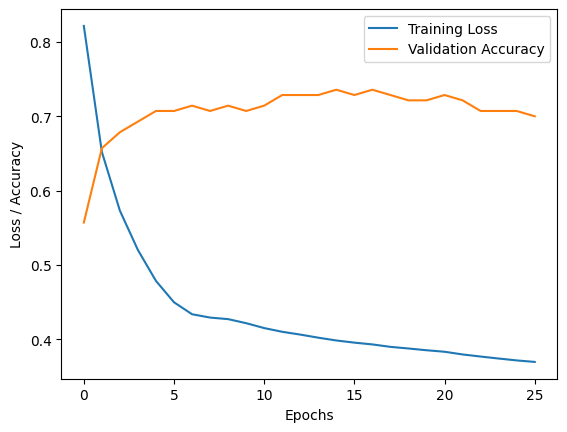

In [ ]:
plt.figure()
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.plot(mlp.validation_scores_, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()